In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq

In [0]:
import requests

In [0]:
# download dataset from google drive
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [0]:
url_sg = "https://drive.google.com/open?id=1NVglfRzNxXI5VZ-HSxqAQWIxicrUFa1i"
file_id = '1NVglfRzNxXI5VZ-HSxqAQWIxicrUFa1i'
destinationSG = '/content/grab-posis-city=Singapore.zip'

In [0]:
download_file_from_google_drive(file_id, destinationSG)

In [0]:
import zipfile
directorySG = destinationSG

In [0]:
zip_ref = zipfile.ZipFile(directorySG, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

#Load Dataset

In [0]:
dataset_SG = pq.ParquetDataset('/tmp/city=Singapore')
dataset_SG = dataset_SG.read()
dataset_SG = dataset_SG.to_pandas()

# SG dataset preprocess

In [0]:
dataset_SG['pingtimestamp'] = pd.to_datetime(dataset_SG['pingtimestamp'], unit='s')pd.DatetimeIndex(data.pingtimestamp).tz_localize('UTC').tz_convert('Asia/Singapore')
SG_car = dataset_SG.drop(columns=['driving_mode'])
del dataset_SG

In [0]:
SG_car['trj_id'] = SG_car['trj_id'].astype('int')

In [0]:
SG_car = SG_car.sort_values(by=['trj_id', 'pingtimestamp'])

In [0]:
# get the travel time by substracting difference in first pingtimestamp with the last pingtimestamp for each trajectory ID
SG_car['travel_time'] = SG_car.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.max() - x.min()).astype('timedelta64[s]')
SG_car['pickup_time'] = SG_car.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.min())
SG_car['dropoff_time'] = SG_car.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.max())

In [0]:
# collect garbage, run when RAM is almost full or just need to clear up RAM
import gc
gc.collect()

0

In [0]:
def extractCoordinateAndUpdateDF(df, variable_name, timestamp_col, coordinate_component):
  """ Create new column containing a coordinate component of geolocation at a certain timestamp"""
  coord_series = df.groupby(['trj_id']).apply(lambda x: x[x['pingtimestamp'] == x[timestamp_col]][coordinate_component])
  coord_series = coord_series.reset_index().set_index('level_1')
  df_update = df.merge(coord_series, how='left', left_on='trj_id', right_on='trj_id', suffixes=['', '_{}'.format(variable_name)])
  return df_update

In [0]:
# create and merge pickup latitude into SG_car
SG_car = extractCoordinateAndUpdateDF(SG_car, 'pickup', 'pickup_time', 'rawlat')
# create and merge pickup longitude into SG_car
SG_car = extractCoordinateAndUpdateDF(SG_car, 'pickup', 'pickup_time', 'rawlng')
# add drop off latitude
SG_car = extractCoordinateAndUpdateDF(SG_car, 'dropoff', 'dropoff_time', 'rawlat')
# add drop off longitude
SG_car = extractCoordinateAndUpdateDF(SG_car, 'dropoff', 'dropoff_time', 'rawlng')

In [0]:
SG_car

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
1,2,android,2019-04-09 02:38:49,1.270338,103.858102,25.457024,97,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
2,2,android,2019-04-09 02:38:50,1.270311,103.858331,25.561169,93,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
3,2,android,2019-04-09 02:38:51,1.270296,103.858560,25.458790,93,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
4,2,android,2019-04-09 02:38:52,1.270282,103.858786,25.312450,87,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30329680,84000,android,2019-04-18 12:52:41,1.287496,103.845757,8.407369,296,3.9,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468
30329681,84000,android,2019-04-18 12:52:42,1.287538,103.845686,9.100465,300,3.9,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468
30329682,84000,android,2019-04-18 12:52:43,1.287584,103.845613,9.546059,301,3.9,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468
30329683,84000,android,2019-04-18 12:52:44,1.287630,103.845540,9.507404,303,4.0,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468


In [0]:
SG_car = SG_car.reset_index()
SG_car = SG_car.drop(labels=['index'], axis=1)

# Preprocess hour and day to cyclical data
we will use sin and cos function to model the time and day into a continuos cyclical cycle.

In [0]:
SG_car_aug_colapse = SG_car.drop_duplicates(subset=['trj_id', 'pickup_time'], keep='first')
# add pickup_hour and pickup_day column
SG_car_aug_colapse['pickup_hour'] = SG_car_aug_colapse['pickup_time'].dt.hour
SG_car_aug_colapse['pickup_day'] = SG_car_aug_colapse['pickup_time'].dt.dayofweek
SG_car_aug_colapse['sin_pickup_hour'] = np.sin(2*np.pi*SG_car_aug_colapse.pickup_hour/24)
SG_car_aug_colapse['cos_pickup_hour'] = np.cos(2*np.pi*SG_car_aug_colapse.pickup_hour/24)
SG_car_aug_colapse['sin_pickup_day'] = np.sin(2*np.pi*SG_car_aug_colapse.pickup_day/7)
SG_car_aug_colapse['cos_pickup_day'] = np.cos(2*np.pi*SG_car_aug_colapse.pickup_day/7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [0]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490
1134,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969
2067,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521
2946,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521
4107,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30323980,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000
30325037,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490
30325931,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490
30327120,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521


# Analysis

In [0]:
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']].values,
                    SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [0]:
SG_car_aug_colapse.loc[:, 'pickup_cluster'] = kmeans.predict(SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']])
SG_car_aug_colapse.loc[:, 'dropoff_cluster'] = kmeans.predict(SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

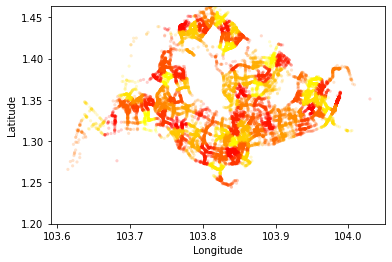

In [0]:
city_long_border = (103.590506, 104.050822)
city_lat_border = (1.199654, 1.463254)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(SG_car_aug_colapse.rawlng_pickup.values[:500000], SG_car_aug_colapse.rawlat_pickup.values[:500000], s=10, lw=0,
           c=SG_car_aug_colapse.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()



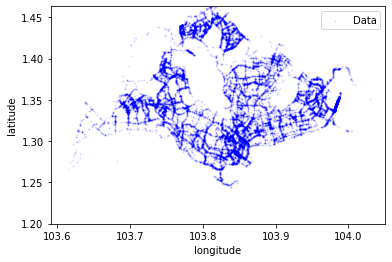

In [0]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(SG_car_aug_colapse['rawlng_pickup'].values[:100000], SG_car_aug_colapse['rawlat_pickup'].values[:100000],
              color='blue', s=1, label='Data', alpha=0.1)
ax.legend(loc=0)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

# Feature Extraction

In [0]:
from sklearn.decomposition import PCA
pca = PCA().fit(coords)

SG_car_aug_colapse['pickup_pca0'] = pca.transform(SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']])[:, 0]
SG_car_aug_colapse['pickup_pca1'] = pca.transform(SG_car_aug_colapse[['rawlat_pickup', 'rawlng_pickup']])[:, 1]
SG_car_aug_colapse['dropoff_pca0'] = pca.transform(SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']])[:, 0]
SG_car_aug_colapse['dropoff_pca1'] = pca.transform(SG_car_aug_colapse[['rawlat_dropoff', 'rawlng_dropoff']])[:, 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [0]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day,pickup_cluster,dropoff_cluster,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490,83,49,-0.025486,-0.076384,0.041837,0.094437
1134,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969,21,55,-0.017611,-0.064838,-0.138717,-0.003314
2067,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521,50,50,-0.023023,0.008731,-0.019494,-0.003787
2946,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521,65,42,0.062661,-0.014213,-0.064685,-0.039977
4107,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969,40,87,-0.114666,-0.004423,0.001871,-0.039493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30323980,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000,32,18,0.095710,0.039577,-0.006699,-0.028723
30325037,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490,32,13,0.095859,0.039224,-0.004703,-0.026205
30325931,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490,42,63,-0.064071,-0.041795,0.065966,0.056133
30327120,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521,37,55,-0.018864,-0.048636,-0.142380,0.005511


# Modelling

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train, test = train_test_split(SG_car_aug_colapse, test_size=0.5, train_size = 0.5)
validate, test = train_test_split(test, test_size = 0.3, train_size = 0.7)
print(len(train))
print(len(validate))
print(len(test))

14000
9800
4200


In [0]:
X_train = train.drop(['travel_time', 'trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)
Y_train = train["travel_time"]
X_val = validate.drop(['travel_time', 'trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)
Y_val = validate["travel_time"]
X_test = test.drop(['travel_time', 'trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)
Y_test = test["travel_time"]

In [0]:
import timeit
"""start = timeit.default_timer()
main()
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))"""

'start = timeit.default_timer()\nmain()\nend = timeit.default_timer()\nprint("Time taken in seconds:{}".format(end-start))'

## Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
start = timeit.default_timer()
regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:0.009276371000396466


In [0]:
#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

11898732104133.004
[ 1.30384624e+09  4.55157024e+10  7.02609259e+08 -1.60129560e+11
  1.25258303e+00  2.50054049e+01  1.02718401e+01 -5.76543670e+01
 -4.87506360e+01 -7.78621941e+01 -1.86798096e-01 -1.74465179e-01
  4.52088828e+10 -5.43471250e+09 -1.59530836e+11  1.38521487e+10]


In [0]:
y_pred = regressor.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 311.27


## Lasso

In [0]:
from sklearn.linear_model import Lasso

In [0]:
start = timeit.default_timer()
clf = Lasso(alpha=0.1).fit(X_train,Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:0.08657063999999082


In [0]:
pred = clf.predict(X_test)
clf.predict(X_test)

array([1398.63609485, 1234.64704461, 1147.32397809, ..., 1137.87290543,
       1030.05216201, 1164.57855672])

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 311.26


In [0]:
from sklearn.linear_model import LassoLarsCV

In [0]:
start = timeit.default_timer()
reg = LassoLarsCV(cv=20).fit(X_train, Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))
reg.score(X_train, Y_train)
reg.alpha_


Time taken in seconds:0.3011523740001394


0.003010610557760974

In [0]:
pred = reg.predict(X_test)
reg.predict(X_test)

array([1400.21301518, 1232.51767516, 1142.4611765 , ..., 1138.8601614 ,
       1031.05251216, 1165.58475859])

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 311.25


## Ridge

In [0]:
from sklearn.linear_model import Ridge

In [0]:
start = timeit.default_timer()
rng = np.random.RandomState(0)
clf = Ridge(alpha=1.0)
clf.fit(X_train, Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:0.007836826999664481


In [0]:
pred = clf.predict(X_test)

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 311.27


## MLP

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
start = timeit.default_timer()
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:6.378694500000165


In [0]:
pred = regr.predict(X_test)
regr.predict(X_test)


array([1395.55614328, 1240.21521989, 1151.0822606 , ..., 1136.97303753,
       1033.10646054, 1164.42261165])

In [0]:
regr.score(X_test, Y_test)

0.11532647516115756

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 311.22


## Decision Tree

In [0]:
from sklearn import tree
start = timeit.default_timer()
clf = tree.DecisionTreeClassifier().fit(X_train, Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:9.935044340999866


In [0]:
pred = clf.predict(X_test)
clf.predict(X_test)

array([1145.,  758., 1110., ...,  850., 1173., 1101.])

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 447.90


## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

start = timeit.default_timer()
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:25.903971878999982


In [0]:
pred = clf.predict(X_test)
clf.predict(X_test)

array([ 953.,  928., 1189., ..., 1040.,  917., 1277.])

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 398.88


## SVM

In [0]:
from sklearn import svm

start = timeit.default_timer()
regr = svm.SVR()
regr.fit(X_train, Y_train)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:14.246000232999904


In [0]:
pred = regr.predict(X_test)
regr.predict(X_test)

array([1189.92184749, 1180.21727619, 1187.12764103, ..., 1178.18673945,
       1175.82605452, 1180.07117801])

In [0]:
mse = mean_squared_error(Y_test,pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 338.10


## XGBoost

In [0]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [0]:
start = timeit.default_timer()
xgb_pars = {'min_child_weight': 1, 'eta': 0.08, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 4000, watchlist, early_stopping_rounds=40,
      maximize=False, verbose_eval=1)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:1237.82	valid-rmse:1240.68
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 40 rounds.
[1]	train-rmse:1179.7	valid-rmse:1182.65
[2]	train-rmse:1124.75	valid-rmse:1127.83
[3]	train-rmse:1072.61	valid-rmse:1075.86
[4]	train-rmse:1023.14	valid-rmse:1026.58
[5]	train-rmse:976.431	valid-rmse:980.072
[6]	train-rmse:932.164	valid-rmse:936.038
[7]	train-rmse:890.177	valid-rmse:894.33
[8]	train-rmse:850.529	valid-rmse:855.1
[9]	train-rmse:813.129	valid-rmse:817.915
[10]	train-rmse:777.719	valid-rmse:782.757
[11]	train-rmse:744.326	valid-rmse:749.702
[12]	train-rmse:712.875	valid-rmse:718.582
[13]	train-rmse:683.076	valid-rmse:689.245
[14]	train-rmse:654.965	valid-rmse:661.593
[15]	train-rmse:628.476	valid-rmse:635.63
[16]	train-rmse:603.548	valid-rmse:611.016
[17]	train-rmse:580.348	valid-rmse:587.934
[18]	train-rmse:558.365	valid-rmse:566.293
[19]	train-rmse:537.516	valid-rmse:546.157
[20]	train

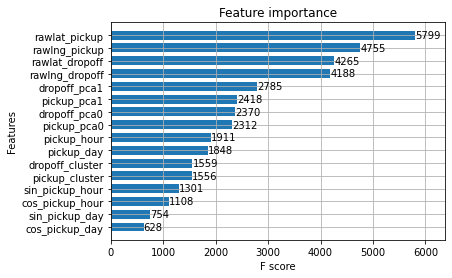

In [0]:
xgb.plot_importance(model, max_num_features=20, height=0.7)

In [0]:
ypred = model.predict(dtest)
mse = mean_squared_error(Y_test,ypred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 244.95


## LightGBM

In [0]:
import lightgbm as lgb

In [0]:
d_train = lgb.Dataset(X_train, label=Y_train)

In [0]:
start = timeit.default_timer()

params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 10000)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Time taken in seconds:7.652873080000063


In [0]:
y_pred = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 199.34


## Catboost

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostRegressor

In [0]:
model = CatBoostRegressor(iterations=10000,
                          learning_rate=0.05,
                          task_type = "GPU",
                          depth=8)
# Fit model
model.fit(X_train, Y_train)


Streaming output truncated to the last 5000 lines.
5001:	learn: 185.4805958	total: 1m 59s	remaining: 1m 59s
5002:	learn: 185.4805589	total: 1m 59s	remaining: 1m 59s
5003:	learn: 185.4805650	total: 1m 59s	remaining: 1m 59s
5004:	learn: 185.4793450	total: 1m 59s	remaining: 1m 59s
5005:	learn: 185.4719694	total: 1m 59s	remaining: 1m 59s
5006:	learn: 185.4719632	total: 1m 59s	remaining: 1m 59s
5007:	learn: 185.4719632	total: 1m 59s	remaining: 1m 59s
5008:	learn: 185.4719509	total: 1m 59s	remaining: 1m 59s
5009:	learn: 185.4719509	total: 1m 59s	remaining: 1m 59s
5010:	learn: 185.4719509	total: 1m 59s	remaining: 1m 59s
5011:	learn: 185.4704782	total: 1m 59s	remaining: 1m 59s
5012:	learn: 185.4704782	total: 1m 59s	remaining: 1m 59s
5013:	learn: 185.4704844	total: 1m 59s	remaining: 1m 59s
5014:	learn: 185.4582032	total: 1m 59s	remaining: 1m 59s
5015:	learn: 185.4581971	total: 1m 59s	remaining: 1m 59s
5016:	learn: 185.4529467	total: 1m 59s	remaining: 1m 59s
5017:	learn: 185.4524167	total: 1m 59

In [0]:
# Get predictions
preds = model.predict(X_test)
mse = mean_squared_error(Y_test,preds)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 243.51
